# BaBar $\sigma(e^+e^- \rightarrow \pi^+\pi^- (\gamma))$

The latest BaBar measurements are published in two papers, a PRL and a later PRD containing more detailed information. Both papers report the cross-section information in the supplemental material, in ASCII files that are identical.

* B. Aubert et al. \[BaBar Collaboration\], [Phys. Rev. Lett. 103 (2009) 231801](https://doi.org/10.1103/PhysRevLett.103.231801), [inspirehep](http://inspirehep.net/record/829441),<br />
"Precise measurement of the e+ e- ---> pi+ pi- (gamma) cross section with the Initial State Radiation method at BABAR"

* J. P. Lees et al. \[BaBar Collaboration\], [Phys. Rev. D 86 (2012) 032013](https://doi.org/10.1103/PhysRevD.86.032013), [inspirehep](http://inspirehep.net/record/1114155),<br />
"Precise Measurement of the e+e−→π+π−(γ)e+e−→π+π−(γ) Cross Section with the Initial-State Radiation Method at BABAR"
  * [data](http://ftp.aip.org/epaps/phys_rev_lett/E-PRLTAO-103-045950/)

The data report the "**bare cross section including FSR**" in nb, and in detail:
* the cross-section and its total undertainty in variable-width bins of energy
* the per-mil relative systematic uncertainty (per energy bin, 100% correlated on all bins)
* the statistical correlation between any two bins of cross-section

In the following the data are used to show a few plots.

In [1]:
using DataFrames
## using DataFramesMeta

using TextParse
using CSV

using FileIO

## using Plots
using StatsPlots
using Measures

using LaTeXStrings
using Query

In [2]:
##
## configure plots
##

## const PLOTS_DEFAULTS = Dict(:theme => :juno)

Plots.default(
  size = (700, 400),
  framestyle = :box,
  tickdirection = :out,
  left_margin = 4pt,
  right_margin = 10pt,
  top_margin = 4pt,
  bottom_margin = 4pt,
)

Plots.pyplot()
## Plots.GRBackend()

Plots.PyPlotBackend()

In [3]:
##
## defs and functions
##

In [4]:
##
## readlines_enh() enhanced readlines() function
## - <skipto> begin reading from indicated line
## - <limit> number of lines to read
##
function readlines_enh(filename::AbstractString; skipto=1, limit=Inf, kw...)
  open(filename) do f
    readlines_enh(f, skipto=skipto, limit=limit; kw...)
  end
end
##
## readlines_enh() from file stream
##
readlines_enh(s=stdin; skipto=1, limit=Inf, kw...) =
  collect(Iterators.take(Iterators.drop(eachline(s; kw...), skipto-1), limit))
nothing

In [5]:
##
## get extrema and extend them by desired amount
##
function extrema_ext(A, ext)
  a, b = extrema(A)
  marg = (b-a)*ext
  a-marg, b+marg
end

extrema_ext (generic function with 1 method)

In [6]:
##
## code
##

In [7]:
##
## read cross-section val and unc of cross-section by energy bin
## - data in lines 30..366
## - format: "2.8  : 2.9           0.009181                 0.0132598"
##
df = DataFrame!(CSV.File(
  "babar-2012/BABAR_ISR2pi_EPAPS.txt",
  skipto=30, limit=337, delim=' ', ignorerepeated=true,
  header=[:E_l, :colon, :E_h, :sigma_val, :sigma_stat_unc]
))
select!(df, Not(:colon))

##--- compute mid-bin energy
transform!(df, [:E_l, :E_h] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E)

display(first(df, 4))
nothing

,E_l,E_h,sigma_val,sigma_stat_unc,E
,Float64,Float64,Float64,Float64,Float64
1,0.3,0.31,25.4904,2.69943,0.305
2,0.31,0.32,35.4801,2.91464,0.315
3,0.32,0.33,45.4858,3.04669,0.325
4,0.33,0.34,51.7825,3.13355,0.335


In [8]:
##
## commented out!
## explore alternative ways of reading the data
##

if false
  ##
  ## use CVSFiles.jl
  ## - fails because it parses the file beyond the specified rows
  ## - not flexible enough to parse multiple whitespace characters as delimiter
  ##
  df = DataFrame(
    load(
      File(format"CSV", "babar-2012/BABAR_ISR2pi_EPAPS.txt"),
      skiplines_begin=30, nrows=337,
      spacedelim=true, header_exists=false)
    )
end

if false
  ##
  ## use CVSFiles.jl after preprocessing the input
  ## - works
  ##
df = readcsv(IOBuffer(
    join(replace.(
        strip.(readlines_enh("babar-2012/BABAR_ISR2pi_EPAPS.txt", skipto=30, limit=337)),
        (r"\s+" => " ",)),
      "\n")
    ),
  hasheader=false, delim=' ', trim=false,
  colnames=[:E_l, :colon, :E_h, :sigma_val, :sigma_unc]
)
end

In [9]:
##
## read cross-section systematic uncertainties
##

##
## read 1 line reporting energy intervals [E_l, E_h] for systematic contributions
## resulting DataFrame ha 1 row with 8 strings of rormat E_l_i,E_h_i 
##
df_tmp = DataFrame!(CSV.File(
  "babar-2012/BABAR_ISR2pi_EPAPS.txt",
  skipto=388, limit=1, delim=' ', ignorerepeated=true,
  header=false
))
##
## convert first row of df_tmp into a vector and then a newline-separated stream
## and then read the stream as a DF with two columns E_l, E_h and 8 rows
##
df_syst = DataFrame!(CSV.File(IOBuffer(join(Vector(df_tmp[1, :]), "\n")), header=[:E_l, :E_h], delim='-'))

##
## read line with systematic unc's for the just read energy intervals, 8 numbers in parenthesis
##
line_tmp = readlines_enh("babar-2012/BABAR_ISR2pi_EPAPS.txt", skipto=401, limit=1)
line_tmp = strip(replace(line_tmp[1],  r"\(([^\)]*)\)" => s"\1"))
##--- read numeric values into DF with 1 row and 8 columns
df_tmp = DataFrame!(CSV.File(IOBuffer(convert(String, line_tmp)),
    delim=' ', ignorerepeated=true, header=false))
##--- remove columns with no data
## df_tmp = df_tmp[!, eltype.(eachcol(df_tmp)) .!= Missing]
##--- add total systematic uncertainties to DF of syst. uncert.
df_syst.unc = Vector(df_tmp[1, :])
##--- compute and add to DF the energy bins mid points
transform!(df_syst, [:E_l, :E_h] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E)
display(first(df_syst, 4))
nothing

,E_l,E_h,unc,E
,Float64,Float64,Float64,Float64
1,0.3,0.4,13.8,0.35
2,0.4,0.5,8.1,0.45
3,0.5,0.6,10.2,0.55
4,0.6,0.9,5.0,0.75


In [10]:
##
## add systematic uncertainty to cross-section DF
##

##--- dictionary to convert mid-point energy to DF index for systematics unc. DF
df_syst_E_exact_to_index = Dict(df_syst[i, :E] => i for i = 1:nrow(df_syst))

##--- get syst covariance as function of energy for the systematic table mid-energy values
function syst_unc_exact(E)
  row = df_syst_E_exact_to_index[E]
  df_syst[row, :unc]
end

##--- get syst covariance as function of two energies: non-zero only for diagonal elements
function syst_cov(E_x, E_y)::AbstractFloat
  row = df_syst_E_exact_to_index[E_x]
  col = df_syst_E_exact_to_index[E_y]
  if (row == col)
    df_syst[row, :unc]^2
  else
    AbstractFloat(0)
  end
end

##--- function to convert any energy into the relevant index into df_syst
function df_syst_e_to_index(E::AbstractFloat)::Union{Integer, Missing}
  row_match::Union{Integer, Missing} = missing
  for row in 1 : nrow(df_syst)
    if (E >= df_syst[row, :E_l] && E <= df_syst[row, :E_h])
      row_match = row
    end
  end
  row_match
end

##--- get syst unc for any energy, finding the correct systematic unc bin
function syst_unc(E)
  row_match = df_syst_e_to_index(E)
  ifelse(ismissing(row_match), missing, df_syst[row_match, :unc])
end

##
## add syst. and total unc.
##
df.sigma_syst_unc = syst_unc.(df.E)
df.sigma_unc = sqrt.(df.sigma_stat_unc.^2 + df.sigma_syst_unc.^2)

display(first(df, 4))

,E_l,E_h,sigma_val,sigma_stat_unc,E,sigma_syst_unc,sigma_unc
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.3,0.31,25.4904,2.69943,0.305,13.8,14.0615
2,0.31,0.32,35.4801,2.91464,0.315,13.8,14.1044
3,0.32,0.33,45.4858,3.04669,0.325,13.8,14.1323
4,0.33,0.34,51.7825,3.13355,0.335,13.8,14.1513


In [11]:
##
## commented out!
## alternative ways to read statistical covariance
##

if false
  ##
  ## read CSV
  ##
  ## fails with: SystemError: memory mapping failed: Cannot allocate memory
  ## use_mmap=false does not seem to work
  ## sudo sysctl vm.max_map_count
  ## sudo sysctl -w vm.max_map_count=655300
  ##
  df_stat = DataFrame!(CSV.File(
    "babar-2012/BABAR_ISR2pi_EPAPS.txt",
    skipto=406, limit=337*337, delim=' ', ignorerepeated=true,
    header=false, use_mmap=false
  ))
end

if false
  ##
  ## use CSVFiles.jl
  ## - reads one row more, cannot limit using nrows, last line is "missing"
  ##
  df_stat = DataFrame(
    load(
      File(format"CSV", "babar-2012/BABAR_ISR2pi_EPAPS.txt"),
      skiplines_begin=406, nrows=337*337,
      spacedelim=true, header_exists=false)
    )
end

if false
  ##
  ## use TableReader
  ## - works
  ## - needs additional code to select requested rows
  ## - TableReader precompilation fails in Julia 1.3
  ##
  df_stat = readcsv(
    IOBuffer(join(Vector(readlines_enh(
            "babar-2012/BABAR_ISR2pi_EPAPS.txt",skipto=407, limit=337*337)), "\n")),
    hasheader=false
  )
end

if false
  ##
  ## TextParse.csvread
  ## returns (([<float>],), Any[1])
  ##
  df_stat = TextParse.csvread(IOBuffer(
      join(Vector(strip.(readlines_enh(
              "babar-2012/BABAR_ISR2pi_EPAPS.txt", skipto=407, limit=1))), "\n")),
    spacedelim=true, header_exists=false, colparsers=Dict(1 => Float64)
  )
end

if false
  ##
  ## DelimitedFiles.readdlm
  ## works
  ##
  df_stat = DataFrame(readdlm(IOBuffer(
        join(Vector(strip.(readlines_enh(
                "babar-2012/BABAR_ISR2pi_EPAPS.txt", skipto=407, limit=337*337))), '\n')
        ), ' ', Float64))
end

In [12]:
##
## commented out!
## get statistical covariance, alternative old way
##

if false

##
## the txt file lists the statistical covariance row by row using the energy bins
## defined for reporting the cross section, in the same order
##

df_stat = DataFrame(cov=parse.(Float64, strip.(
      readlines_enh("babar-2012/BABAR_ISR2pi_EPAPS.txt", skipto=407, limit=337*337))))

##
## build a dataframe where for each covariance coefficient one reports
## the covariance matrix row and column energy bin lower and higher limit
##

##--- vectors of all low and high E bin limits
E_l_vec = Vector(df[:, :E_l])
E_h_vec = Vector(df[:, :E_h])
##--- vector of tuples, each containing low/high E bin limits
E_lh = [ [E_l_vec[i], E_h_vec[i]] for i in 1:nrow(df) ]
##--- matrix containing pairs of energy bins tuples, each containing high/low bounds
E_lh_sq = [ [x, y] for x = E_lh, y = E_lh ]

##
## add to Dataframe of statistical covariance
## - column E low
## - column E high
## - row E low
## - row E high
## - column E mid
## - row E mid
##
insertcols!(df_stat, 1, :E_l_c => [E_lh_sq[i][1][1] for i in 1:length(E_lh_sq)])
insertcols!(df_stat, 2, :E_h_c => [E_lh_sq[i][1][2] for i in 1:length(E_lh_sq)])
insertcols!(df_stat, 3, :E_l_r => [E_lh_sq[i][2][1] for i in 1:length(E_lh_sq)])
insertcols!(df_stat, 4, :E_h_r => [E_lh_sq[i][2][2] for i in 1:length(E_lh_sq)])
insertcols!(df_stat, 1, :E_c => (df_stat[:, :E_l_c]+df_stat[:, :E_h_c])/2)
insertcols!(df_stat, 2, :E_r => (df_stat[:, :E_l_r]+df_stat[:, :E_h_r])/2)
display(first(df_stat, 4))
display(df_stat)
nothing

end

In [13]:
##
## get statistical covariance
##

##
## the txt file lists the statistical covariance row by row using the energy bins
## defined for reporting the cross section
## there are N energy bins, the covariance is a matrix with rows and colums
## the first values are for columns 1:N and row=1
## the next values are for columns 1:N and row=2 and so on
##

df_stat = DataFrame(cov = parse.(Float64, strip.(
      readlines_enh("babar-2012/BABAR_ISR2pi_EPAPS.txt", skipto=407, limit=337*337))))

##
## build a dataframe where for each covariance coefficient we have:
## - column central energy, low edge of energy bin, high edge of energy bin
## - same as above for the row
## this dataframe is used for doing a contour plot
##

df_stat.E_l_c = repeat(df.E_l, outer=nrow(df))
df_stat.E_h_c = repeat(df.E_h, outer=nrow(df))
df_stat.E_l_r = repeat(df.E_l, inner=nrow(df))
df_stat.E_h_r = repeat(df.E_h, inner=nrow(df))
transform!(df_stat, [:E_l_c, :E_h_c] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E_c)
transform!(df_stat, [:E_l_r, :E_h_r] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E_r)

display(first(df_stat, 4))
nothing

,cov,E_l_c,E_h_c,E_l_r,E_h_r,E_c,E_r
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,7.16412,0.3,0.31,0.3,0.31,0.305,0.305
2,0.811213,0.31,0.32,0.3,0.31,0.315,0.305
3,0.0292493,0.32,0.33,0.3,0.31,0.325,0.305
4,0.216073,0.33,0.34,0.3,0.31,0.335,0.305


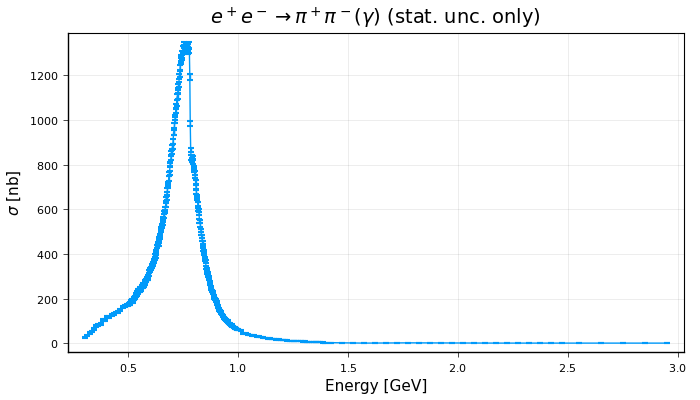

In [14]:
##
## plot cross-section vs. energy (stat. unc. only)
##
pl1 = @df df plot(
  :E,
  :sigma_val,
  yerror=:sigma_stat_unc,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$ (stat. unc. only)",
  xlabel="Energy [GeV]",
  ylabel=L"$\sigma$ [nb]",
  markerstrokecolor = :auto,
  legend = false
)
## savefig(pl1, "plot.pdf")
## display(pl1)

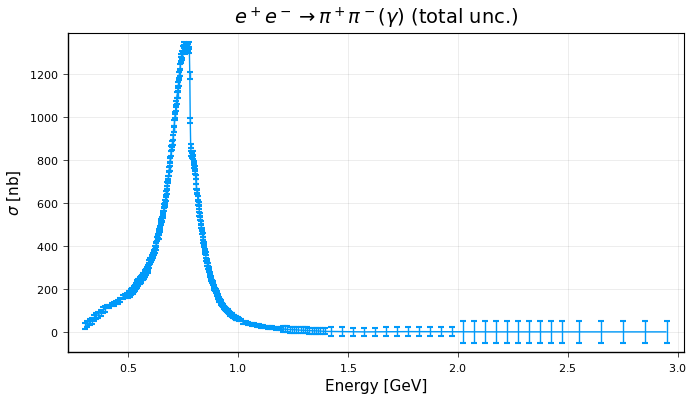

In [15]:
##
## plot cross-section vs. energy (total unc.)
##
pl1tot = @df df plot(
  :E,
  :sigma_val,
  yerror=:sigma_unc,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$ (total unc.)",
  xlabel="Energy [GeV]",
  ylabel=L"$\sigma$ [nb]",
  markerstrokecolor = :auto,
  legend = false
)
## savefig(pl1tot, "plot.pdf")
## display(pl1tot)

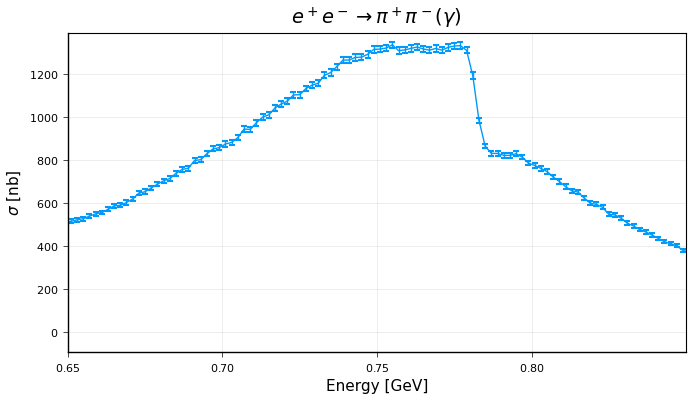

In [16]:
##
## plot cross-section vs. energy around rho / omega interference
##
pl2 = @df df plot(
  :E,
  :sigma_val,
  yerror=:sigma_unc,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$",
  xlabel="Energy [GeV]",
  ylabel=L"$\sigma$ [nb]",
  markerstrokecolor = :auto,
  legend = false,
  xlim=(0.65,0.85)
)
## savefig(pl2, "plot.pdf")
## display(pl2)

In [17]:
##
## plot statistical covariance surface plot
##
pl3 = @df df_stat surface(
  :E_c,
  :E_r,
  :cov,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  ## zlabel="σ covariance",
  camera=(0, 90),
  clims = (minimum(:cov)-0.2*(maximum(:cov)-minimum(:cov)), maximum(:cov)+0.2*(maximum(:cov)-minimum(:cov)))
)
nothing

In [18]:
##
## functions for producing contour plots of stat covariance
##

##--- dictionary to convert mid-point energy to DF index for data and stat. unc. DF
df_E_to_index = Dict(df[i, :E] => i for i = 1:nrow(df))

##--- get covariance as function of two energies
function stat_cov(E_x, E_y)
  row = df_E_to_index[E_x]
  col = df_E_to_index[E_y]
  ##
  ## interpret cov values vector as matrix with n rows and n columns
  ## return appropriate cov value for required row and column
  ##
  reshape(df_stat.cov, (nrow(df), nrow(df)))[row, col]
end
stat_cov_clims = @df df identity( extrema_ext((stat_cov(Ex, Ey) for Ex in :E, Ey in :E), 0.2) )

##--- get correlation as function of two energies
function stat_corr(E_x, E_y)
  row = df_E_to_index[E_x]
  col = df_E_to_index[E_y]
  matr_stat = reshape(df_stat.cov, (nrow(df), nrow(df)))
  matr_stat[row, col] / sqrt(matr_stat[row, row]*matr_stat[col, col])
end
stat_corr_clims = @df df identity( extrema_ext((stat_corr(Ex, Ey) for Ex in :E, Ey in :E), 0.2) )

nothing

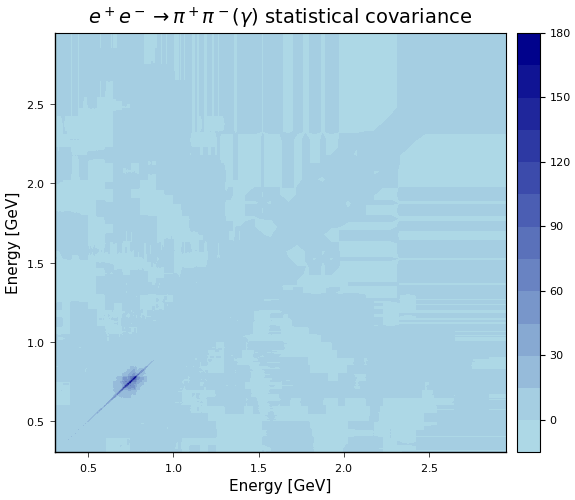

In [19]:
##
## plot statistical covariance contour plot
##
pl3 = @df df contourf(
  :E, :E, stat_cov,
  ## clims = stat_cov_clims,
  color = :blues,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$ statistical covariance",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  size=(575, 500)
)

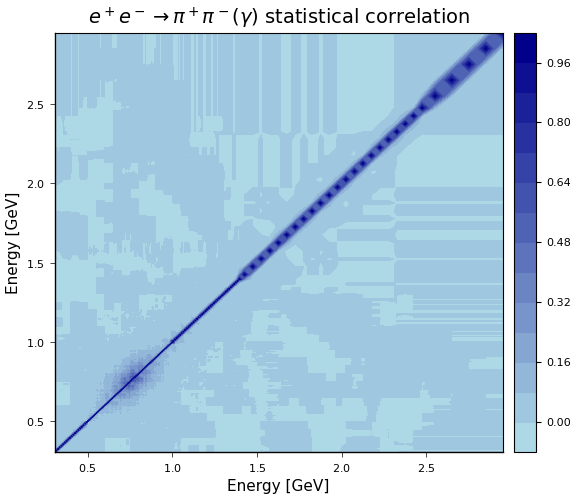

In [20]:
##
## plot statistical correlation contour plot
##
pl3 = @df df contourf(
  :E, :E, stat_corr,
  ## clims = stat_corr_clims,
  color = :blues,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$ statistical correlation",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  size=(575, 500)
)

In [21]:
##
## plot systematic covariance contour plot
## there is no systematic covariance, just diagonal systematic uncertainties
##

syst_cov_clims = @df df_syst identity( extrema_ext((syst_cov(Ex, Ey) for Ex in :E, Ey in :E), 0.2) )
## println("range of covariance values:", cov_clims)
## println("note: color legend is not accurate, does not match custom color limits ", syst_cov_clims)

##
## plot
##
pl4 = @df df_syst contourf(
  :E, :E, syst_cov,
  ## clims = syst_cov_clims,
  color = :blues,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$ systematic covariance",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  size=(575, 500)
)

nothing